In [1]:
#defining function to read MIDI files
from music21 import *

def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    part=s2.parts[0]
        
    notes_to_parse = part.recurse() 

    #finding whether a particular element is note or a chord
    for element in notes_to_parse:
        
        #note
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        
        #chord
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes

/Users/bhargaviramadugu/Desktop/Gopi/notebooks/py3/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#for listing down the file names
import os

#Array Processing
import numpy as np
import pandas as pd

#specify the path
path='music/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array=[]

for i in files:
    data=read_midi(path+i)
    print(len(data))
    try:
        notes_array=notes_array+data
    except Exception as e:
        print("failed for",i,e)


Loading Music File: music/Castle_House_Rag_RW_e.mid
975
Loading Music File: music/Am_I_Blue_AB_e.mid
1557
Loading Music File: music/Kinkajou__Perrella_LW_e.mid
965
Loading Music File: music/Nola__Arndt__Arndt_1915_DA_e.mid
1313


In [3]:
len(notes_array),len(set(notes_array))

(4810, 888)

<Axes: xlabel='0'>

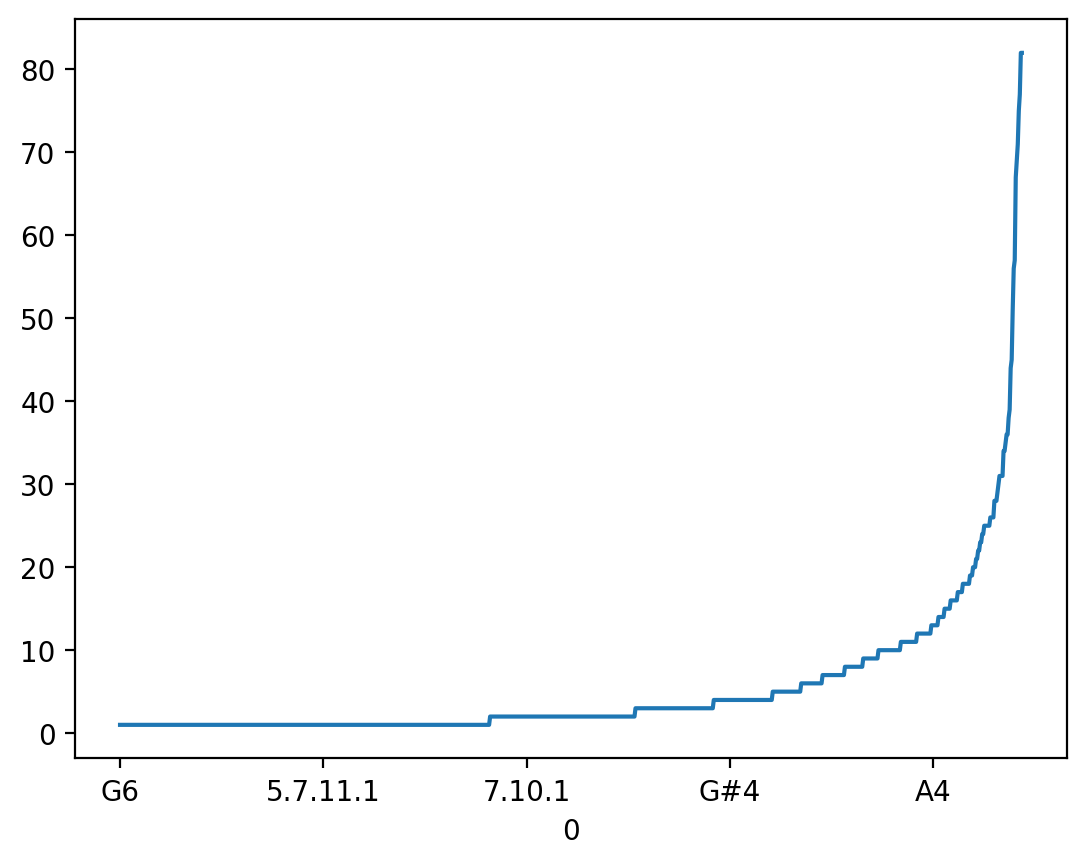

In [4]:
series=pd.Series(notes_array)
counts=pd.DataFrame(series).groupby(0)[0].count()
counts.sort_values().plot()

In [5]:
min_freq=30
counts[counts>min_freq].shape


(23,)

In [6]:
frequent_notes=list(counts[counts>min_freq].index)
frequent_notes=list(filter(lambda x:'.' in x,frequent_notes))
len(frequent_notes)

12

In [7]:
note_to_int={frequent_notes[i]:float(i) for i in range(0,len(frequent_notes))}
note_to_int

{'0.4.7': 0.0,
 '11.2': 1.0,
 '2.7': 2.0,
 '4.5': 3.0,
 '5.9': 4.0,
 '5.9.0': 5.0,
 '7.0': 6.0,
 '8.1': 7.0,
 '9.0': 8.0,
 '9.0.2.5': 9.0,
 '9.0.4': 10.0,
 '9.11': 11.0}

In [8]:
new_music=[]

for note in notes_array:


    if note in frequent_notes:
        new_music.append([note_to_int[note]])            
    
len(new_music)

533

In [9]:
def seq_to_xy(seq,window=2):
    X=[]
    Y=[]
    for i in range(0,len(seq)-window):
        X.append(seq[i:i+window])
        Y.append(seq[i+window])
    return X,Y

In [10]:
window=30
X,Y=seq_to_xy(new_music,window)

In [11]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
def ann():
  model = Sequential()
  model.add(LSTM(5,return_sequences=True))
  model.add(LSTM(5))
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dense(len(frequent_notes)))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [12]:
model=ann()

In [13]:
history = model.fit(np.array(X),np.array(Y),batch_size=128,epochs=50, verbose=1)


Epoch 1/50
4/4 [==============================] - 1s 11ms/step - loss: 2.4826
Epoch 2/50
4/4 [==============================] - 0s 8ms/step - loss: 2.4781
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 2.4740
Epoch 4/50
4/4 [==============================] - 0s 11ms/step - loss: 2.4695
Epoch 5/50
4/4 [==============================] - 0s 8ms/step - loss: 2.4651
Epoch 6/50
4/4 [==============================] - 0s 8ms/step - loss: 2.4606
Epoch 7/50
4/4 [==============================] - 0s 8ms/step - loss: 2.4557
Epoch 8/50
4/4 [==============================] - 0s 8ms/step - loss: 2.4513
Epoch 9/50
4/4 [==============================] - 0s 8ms/step - loss: 2.4465
Epoch 10/50
4/4 [==============================] - 0s 8ms/step - loss: 2.4406
Epoch 11/50
4/4 [==============================] - 0s 7ms/step - loss: 2.4367
Epoch 12/50
4/4 [==============================] - 0s 7ms/step - loss: 2.4315
Epoch 13/50
4/4 [==============================] - 0s 8ms/step - loss: 

In [14]:
import random
ind = np.random.randint(0,len(X)-1)

random_music = np.array(X)[ind]
predictions=[]
for i in range(1000):

    random_music = random_music.reshape(1,window)

    prob  = model.predict(random_music)[0]
    y_pred= random.choices(range(0,len(prob)),weights=prob,k=1)[0]
    predictions.append(frequent_notes[int(y_pred)])

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    


1/1 [==============================] - 0s 9ms/step


In [15]:
from music21 import note as note
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        
        if ('.' in pattern) or pattern.isdigit():
            
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            continue
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='AI_music.mid')

In [16]:
convert_to_midi(predictions)